In [ ]:
import cv2
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import pandas as pd
from PIL import Image
import imutils
from openpyxl import Workbook
import os, os.path
import re
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout, Activation
from keras.utils import to_categorical
from tensorflow.keras.callbacks import ModelCheckpoint
pwd

In [84]:
#Function to display image
def show(show_img):
    cv2.imshow("Image", show_img) 
    cv2.waitKey(0)

In [113]:
test_image = cv2.imread("test_ideal1.jpg")

show(test_image)

In [107]:
#Segmenting the Studet ID
r= (90,50,198,47)

# Crop image
ROI_ID = test_image[int(r[1]):int(r[1]+r[3]), int(r[0]):int(r[0]+r[2])]

# Display cropped image
cv2.imshow("Image", ROI_ID)
cv2.waitKey(0)


-1

In [114]:
#Segmenting the Marks Column
#r=( 563 , 86 , 137, 759)

r = ( 563 , 86 , 137, 759)
# Crop image
ROI_marks = test_image[int(r[1]):int(r[1]+r[3]), int(r[0]):int(r[0]+r[2])]
#ROI_marks = cv2.imread("cPNG.png")
# Display cropped image
cv2.imshow("Image", ROI_marks)
cv2.waitKey(0)

-1

In [5]:
#Function to sort the contours
def sort_contours(cnts, method="left-to-right"):
    # initialize the reverse flag and sort index
    reverse = False
    i = 0

    # handle if we need to sort in reverse
    if method == "right-to-left" or method == "bottom-to-top":
        reverse = True

    # handle if we are sorting against the y-coordinate rather than
    # the x-coordinate of the bounding box
    if method == "top-to-bottom" or method == "bottom-to-top":
        i = 1

    # construct the list of bounding boxes and sort them from top to
    # bottom
    boundingBoxes = [cv2.boundingRect(c) for c in cnts]
    (cnts, boundingBoxes) = zip(*sorted(zip(cnts, boundingBoxes),
        key=lambda b:b[1][i], reverse=reverse))

    # return the list of sorted contours and bounding boxes
    return (cnts, boundingBoxes)


#Function for segmenting cells from each column
def box_extraction(img_for_box_extraction_path, cropped_dir_path):
    # Read the image
    img = img_for_box_extraction_path
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY) 

    # Thresholding the image
    (thresh, img_bin) = cv2.threshold(img, 150, 255,cv2.THRESH_BINARY|     cv2.THRESH_OTSU)
    # Invert the image
    img_bin = 255-img_bin 
    cv2.imshow("Image", img_bin) 
    cv2.waitKey(0)


    # Defining a kernel length
    kernel_length = np.array(img).shape[1]//40


    # A verticle kernel of (1 X kernel_length), which will detect all the verticle lines from the image.
    verticle_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (1, kernel_length))
    # A horizontal kernel of (kernel_length X 1), which will help to detect all the horizontal line from the image.
    hori_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (kernel_length, 1))
    # A kernel of (3 X 3) ones.
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (3, 3))


    # Morphological operation to detect vertical lines from an image
    img_temp1 = cv2.erode(img_bin, verticle_kernel, iterations=3)
    verticle_lines_img = cv2.dilate(img_temp1, verticle_kernel, iterations=3)
    cv2.imwrite("verticle_lines.jpg",verticle_lines_img)
    cv2.imshow("Image", verticle_lines_img) 
    cv2.waitKey(0)

    # Morphological operation to detect horizontal lines from an image
    img_temp2 = cv2.erode(img_bin, hori_kernel, iterations=3)
    horizontal_lines_img = cv2.dilate(img_temp2, hori_kernel, iterations=3)

    cv2.imshow("Image", horizontal_lines_img) 
    cv2.waitKey(0)

    # Weighting parameters, this will decide the quantity of an image to be added to make a new image.
    alpha = 0.5
    beta = 1.0 - alpha
    # This function helps to add two image with specific weight parameter to get a third image as summation of two image.
    img_final_bin = cv2.addWeighted(verticle_lines_img, alpha, horizontal_lines_img, beta, 0.0)
    img_final_bin = cv2.erode(~img_final_bin, kernel, iterations=1)
    (thresh, img_final_bin) = cv2.threshold(img_final_bin, 128,255, cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)

    cv2.imshow("Image", img_final_bin) 
    cv2.waitKey(0)

    # Find contours for image, which will detect all the boxes
    contours, hierarchy = cv2.findContours(img_final_bin, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    # Sort all the contours by top to bottom.
    (contours, boundingBoxes) = sort_contours(contours, method="top-to-bottom")


    idx = 0
    for c in contours:
        # Returns the location and width,height for every contour
        x, y, w, h = cv2.boundingRect(c)
        if (w > 80 and h > 7):
            while idx>0:
                
                check_img = img[y:y+h, x:x+w]
                
                thresh = cv2.threshold(check_img, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)[1]

                # Remove horizontal
                horizontal_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (25,1))
                detected_lines = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, horizontal_kernel, iterations=1)
                cnts = cv2.findContours(detected_lines, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
                cnts = cnts[0] if len(cnts) == 2 else cnts[1]
                for c in cnts:
                    cv2.drawContours(check_img, [c], -1, (255,255,255), 2)

                # Repair image
                repair_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (1,6))
                result = 255 - cv2.morphologyEx(255 - check_img, cv2.MORPH_CLOSE, repair_kernel, iterations=1)

                # cv2.imshow('thresh', thresh)
                # cv2.imshow('detected_lines', detected_lines)
                cv2.imshow('image', check_img)
                # cv2.imshow('result', result)
                cv2.waitKey()
                cv2.imwrite(cropped_dir_path+str(idx) + '.png', check_img)
                break
            idx += 1




In [115]:
#Extraction of cells
box_extraction(ROI_marks, "./CroppedCells/Marks/")

In [8]:
#Function for segmenting digits in a cell
def digits_in_cell(index,cropped_dir_path):

    cell_img = cv2.imread(cropped_dir_path+str(index) + '.png')
    #image = imutils.resize(image,width=320)
    gray = cv2.cvtColor(cell_img,cv2.COLOR_BGR2GRAY)

    kernel = cv2.getStructuringElement(cv2.MORPH_RECT,(3,3))
    blackhat = cv2.morphologyEx(gray,cv2.MORPH_BLACKHAT,kernel)

    _,thresh = cv2.threshold(blackhat,0,255,cv2.THRESH_BINARY|cv2.THRESH_OTSU)
    thresh = cv2.dilate(thresh,None)

    (cnts,_) = cv2.findContours(thresh.copy(),cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_SIMPLE)
    (cnts, boundingBoxes) = sort_contours(cnts)
    avgCntArea = np.mean([cv2.contourArea(k) for k in cnts])
    digits = []
    boxes = []

    for (i,c) in enumerate(cnts):
        if cv2.contourArea(c)<avgCntArea:
            continue
        mask = np.zeros(gray.shape,dtype="uint8")
        (x,y,w,h) = cv2.boundingRect(c)
        hull = cv2.convexHull(c)
        cv2.drawContours(mask,[hull],-1,255,-1)
        mask = cv2.bitwise_and(thresh,thresh,mask=mask)
        digit = mask[y-8:y+h+8,x-8:x+w+8]
        shape=digit.shape
        if shape[0] == 0 or shape[1] == 0:
            continue
        digit = cv2.resize(digit,(28,28))
        #print(digit.shape)
        plt.imshow(digit, cmap='gray')
        boxes.append((x,y,w,h))
        digits.append(digit)
     

    i= 1
    for digit in digits:
        cv2.imwrite("./Digits/"+"C" + str(index) + "D" + str(i) + ".png", digit)
        i=i+1
        cv2.imshow("Image", digit) 
        cv2.waitKey(0)


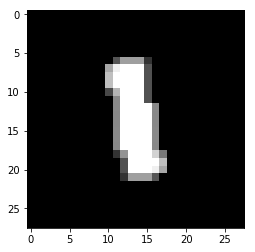

In [116]:
FILE_PATH = r"./CroppedCells/Marks/"
filenames = os.listdir(FILE_PATH)
filenames.remove('.ipynb_checkpoints')
filenames.sort()
filenames
for filename in filenames:
    #print("File Name: " + filename)
    index = re.sub('\.png$', '', filename)
    digits_in_cell(index,FILE_PATH)

# Model

In [117]:
#Loading MNIST train and test data

train_df = pd.read_csv("./Data/train.csv")
test_df = pd.read_csv("./Data/test.csv")

In [11]:
train_df

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6,7,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8,5,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [12]:
# training images
X_train = train_df.drop('label', 1).to_numpy().reshape(len(train_df),28,28,1).astype('float32')
X_train /= 255

# training lables          
y_train = to_categorical(train_df['label'],10)



# test images
X_test = test_df.to_numpy().reshape(len(test_df),28,28,1).astype('float32')
X_test /= 255



In [13]:
#CNN

model = Sequential()
model.add(Conv2D(32, kernel_size=(2,2), input_shape=(28, 28,1), padding='same', activation='relu'))
model.add(MaxPooling2D())  

model.add(Conv2D(64, kernel_size=(2,2), padding='same', activation='relu'))
model.add(MaxPooling2D())

model.add(Flatten())
model.add(Dense(1024, activation='relu'))
model.add(Dense(10, activation='softmax'))

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


In [14]:
history = model.fit(X_train, y_train, epochs=20, validation_split=0.3)

Train on 29399 samples, validate on 12601 samples
Epoch 1/20
29399/29399 [==============================] - 41s 1ms/sample - loss: 0.1744 - acc: 0.9451 - val_loss: 0.0921 - val_acc: 0.9717
Epoch 2/20
29399/29399 [==============================] - 38s 1ms/sample - loss: 0.0541 - acc: 0.9823 - val_loss: 0.0500 - val_acc: 0.9846
Epoch 3/20
29399/29399 [==============================] - 36s 1ms/sample - loss: 0.0336 - acc: 0.9895 - val_loss: 0.0512 - val_acc: 0.9834
Epoch 4/20
29399/29399 [==============================] - 36s 1ms/sample - loss: 0.0238 - acc: 0.9923 - val_loss: 0.0618 - val_acc: 0.9808
Epoch 5/20
29399/29399 [==============================] - 40s 1ms/sample - loss: 0.0175 - acc: 0.9937 - val_loss: 0.0602 - val_acc: 0.9828
Epoch 6/20
29399/29399 [==============================] - 41s 1ms/sample - loss: 0.0143 - acc: 0.9954 - val_loss: 0.0685 - val_acc: 0.9814
Epoch 7/20
29399/29399 [==============================] - 40s 1ms/sample - loss: 0.0117 - acc: 0.9959 - val_loss: 0.

In [15]:
score_trainset = model.evaluate(X_train, y_train)

42000/42000 [==============================] - 9s 212us/sample - loss: 0.0206 - acc: 0.9967


In [16]:
predicted_classes = model.predict(X_test)
predicted_classes = np.argmax(np.round(predicted_classes),axis=1)

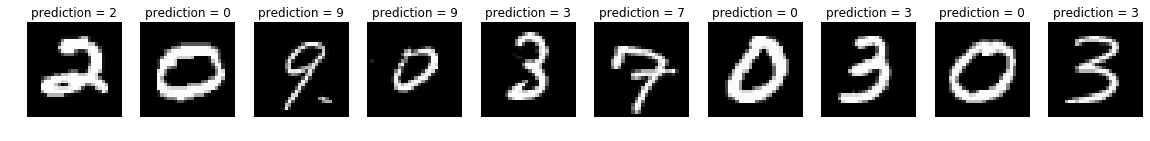

In [17]:
# visualise some predicted labels
f, axarr = plt.subplots(1,10, figsize=(20,20))
for i in range(10):
    image = X_test[i].reshape(28,28)
    axarr[i].axis('off')
    axarr[i].set_title("prediction = " + str(predicted_classes[i]))
    axarr[i].imshow(image, cmap='gray')

# Preprocess segmented image for prediction

In [18]:
DIGIT_PATH = r"./Digits/"
digitfiles = os.listdir(DIGIT_PATH)
digitfiles.remove('.ipynb_checkpoints')
digitfiles.sort()

#Get the maximum nuber of cells
cell_array=[]
for filename in filenames:
    cell_array.append(int(re.sub('\.png$', '', filename)))    

max_cell = max(cell_array)

#gray_images = np.zeros((max_cell, 5)).astype(int)

gray_images = pd.DataFrame(np.zeros((max_cell+10,10)).astype('object'))

def preprocess(cell_number,digit_number,DIGIT_PATH):
    im = cv2.imread(str(DIGIT_PATH) + "C" + str(cell_number) + "D" + str(digit_number) + '.png')
    
    #convert to gray
    gray = cv2.cvtColor(im, cv2.COLOR_BGR2GRAY)

    # resize the images and invert it (black background)
    #gray = cv2.resize(255-gray, (28, 28))
    cell_number = int(cell_number)
    digit_number = int(digit_number)

    thresh, gray = cv2.threshold(gray, 128, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)
    print(gray.shape)
    gray_images[digit_number][cell_number] = gray



for digitfile in digitfiles:
    print("FileName: " + digitfile)
    cell_number = digitfile[digitfile.find("C")+1:digitfile.find("D")]
    digit_number = digitfile[digitfile.find("D")+1:digitfile.find(".")]

    preprocess(cell_number,digit_number,DIGIT_PATH)
    
gray_images

FileName: C10D1.png
(28, 28)
FileName: C11D1.png
(28, 28)
FileName: C11D2.png
(28, 28)
FileName: C12D1.png
(28, 28)
FileName: C12D2.png
(28, 28)
FileName: C13D1.png
(28, 28)
FileName: C13D2.png
(28, 28)
FileName: C14D1.png
(28, 28)
FileName: C14D2.png
(28, 28)
FileName: C15D1.png
(28, 28)
FileName: C15D2.png
(28, 28)
FileName: C1D1.png
(28, 28)
FileName: C2D1.png
(28, 28)
FileName: C3D1.png
(28, 28)
FileName: C4D1.png
(28, 28)
FileName: C4D2.png
(28, 28)
FileName: C5D1.png
(28, 28)
FileName: C5D2.png
(28, 28)
FileName: C6D1.png
(28, 28)
FileName: C6D2.png
(28, 28)
FileName: C7D1.png
(28, 28)
FileName: C7D2.png
(28, 28)
FileName: C8D1.png
(28, 28)
FileName: C8D2.png
(28, 28)
FileName: C9D1.png
(28, 28)
FileName: C9D2.png
(28, 28)


,0,1,2,3,4,5,6,7,8,9
0,0,0,0,0,0,0,0,0,0,0
1,0,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",0,0,0,0,0,0,0,0
2,0,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",0,0,0,0,0,0,0,0
3,0,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",0,0,0,0,0,0,0,0
4,0,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",0,0,0,0,0,0,0
5,0,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",0,0,0,0,0,0,0
6,0,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",0,0,0,0,0,0,0
7,0,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",0,0,0,0,0,0,0
8,0,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",0,0,0,0,0,0,0
9,0,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",0,0,0,0,0,0,0


In [19]:
col = [x for x in range(784)]
col = ["Key"] + col
col
pixels_with_key = pd.DataFrame(columns=col)

keys = []


for digitfile in digitfiles:
    cell_number = int(digitfile[digitfile.find("C")+1:digitfile.find("D")])
    digit_number = int(digitfile[digitfile.find("D")+1:digitfile.find(".")])
    #Create Key for each image
    key = re.sub('\.png$', '', digitfile)
    keys.append(key)

pixels_with_key["Key"] = keys

#pixels_with_key = pixels_with_key.set_index("Key")
#pixels_with_key.set_index('Key')
pixels_with_key.set_index('Key',inplace=True)




for digitfile in digitfiles:
    cell_number = int(digitfile[digitfile.find("C")+1:digitfile.find("D")])
    digit_number = int(digitfile[digitfile.find("D")+1:digitfile.find(".")])

    img_converted =  gray_images[digit_number][cell_number]
    

    # flatten
    row =  img_converted.ravel()

    # convert to list
    row_as_list = row.tolist()
    a = "C"+str(cell_number)+"D"+str(digit_number)
    pixels_with_key.loc[a] = row_as_list
    
pixels_with_key

,0,1,2,3,4,5,6,7,8,9,...,774,775,776,777,778,779,780,781,782,783
Key,,,,,,,,,,,,,,,,,,,,,
C10D1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
C11D1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
C11D2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
C12D1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
C12D2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
C13D1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
C13D2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
C14D1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
C14D2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


pandas.core.frame.DataFrame

In [20]:
predict = pixels_with_key.to_numpy().reshape(len(pixels_with_key),28,28,1).astype('float32')
predict /= 255
predict.shape

(26, 28, 28, 1)

In [118]:
col = ["Question", "Mark"]
predicted_classes_df = pd.DataFrame(columns=col)
predicted_classes_df["Question"] = keys
#predicted_classes_df.set_index('Key',inplace=True).sum()\



predicted_classes = model.predict(predict)
predicted_classes = np.argmax(np.round(predicted_classes),axis=1)


predicted_classes_df["Mark"] = predicted_classes

predicted_classes_df = predicted_classes_df.groupby(predicted_classes_df['Question'].replace(regex=True,to_replace=r'(C[0-9]+).*',value=r'\1'))\
['Mark'].apply(lambda x: ''.join(map(str,x)))



predicted_classes_df =predicted_classes_df.to_frame()
predicted_classes_df.reset_index(level=0, inplace=True)

predicted_classes_df['Question'] =  [re.sub(r'[C\r]*','', str(x)) for x in predicted_classes_df['Question']]



predicted_classes_df['Question'] =  [re.sub(r'[C\r]*','', str(x)) for x in predicted_classes_df['Question']]

predicted_classes_df["Question"] = pd.to_numeric(predicted_classes_df["Question"])

predicted_classes_df = predicted_classes_df.sort_values(by=['Question'])
predicted_classes_df=predicted_classes_df.set_index('Question')
predicted_classes_df.reset_index(level=0, inplace=True)
predicted_classes_df = predicted_classes_df.T
predicted_classes_df



,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
Question,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
Mark,5,7,4,19,32,30,80,33,51,1,97,38,39,49,89


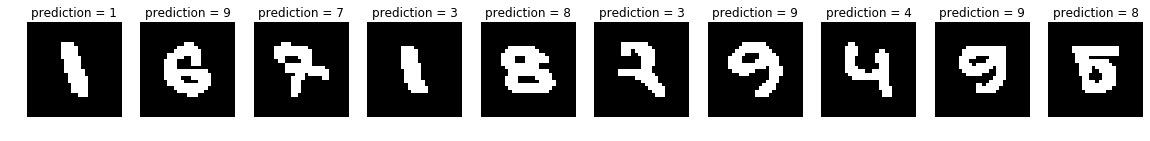

In [22]:
# visualise some predicted labels
f, axarr = plt.subplots(1,10, figsize=(20,20))
for i in range(10):
    image = predict[i].reshape(28,28)
    axarr[i].axis('off')
    axarr[i].set_title("prediction = " + str(predicted_classes[i]))
    axarr[i].imshow(image, cmap='gray')

In [119]:
predicted_classes_df.to_excel("Marks.xlsx") 